In [1]:
import random
import pandas as pd
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt

In [2]:
"""
Separate each asset to independent df
"""

raw_data = pd.read_csv("AIDX.csv", encoding='gbk')

# grouped by index code
grouped_asset = raw_data.groupby("S_IRDCODE")

# only keep dataframe that has more than 200 trading dates
asset_dfs = {ird_code: group for ird_code, group in grouped_asset if len(group) >= 200}

# save each asset independently to csv
for ird_code, grouped_df in asset_dfs.items():
    grouped_df['TRADE_DT'] = pd.to_datetime(grouped_df['TRADE_DT'], format='%Y%m%d')
    grouped_df.sort_values(by='TRADE_DT', inplace=True)
    # grouped_df.to_csv(f"assets/{ird_code}.csv", index=False)

In [3]:
"""
Find the turning point for a df
"""

# my self-defined strategy
def find_turning_point_self(df, direction, n_days=7, fraction_movement=0.01, threshold_day=14, threshold_rate=0.05):
    df = df.reset_index(drop=True)
    record = []
    
    i = 0  # start index
    while i < len(df.index):
        record_i = i
        pattern_find = False
        for n in range(1, n_days+1):
            try:
                current_close = df.loc[i, 'CLOSE']
                ndays_close = df.loc[i+n, 'CLOSE']
                if (ndays_close - current_close) * direction >= (fraction_movement * current_close):
                    pattern_find = True
                    i += n
                    n = 0
            except:
                pass
        if pattern_find:
            start_date = df.loc[record_i, 'TRADE_DT']
            end_date = df.loc[i, 'TRADE_DT']
            start_close = df.loc[record_i, 'CLOSE']
            end_close = df.loc[i, 'CLOSE']
            if (i - record_i) >= threshold_day \
                or (end_close - start_close) * direction >= (threshold_rate * start_close):
                # print(f"Direction: {direction}, Start: {start_date}, End: {end_date}")
                record.append((start_date, end_date))
            else:
                i = record_i
        i += 1
    return record

# moving average strategy
def find_turning_point_ma(df, window_size=30, threshold=0.05, days_after=0):
    df['moving_average'] = df['CLOSE'].rolling(window=window_size).mean()
    df['deviation'] = ((df['CLOSE'] - df['moving_average']) / df['moving_average']).abs()
    df['is_significant_turning_point'] = df['deviation'] > threshold
    significant_turning_points = df[df['is_significant_turning_point']]

    turning_point_periods = []
    for index, row in significant_turning_points.iterrows():
        start_date = row['TRADE_DT']
        current_index = df.index.get_loc(index)
        end_index = min(current_index + days_after, len(df) - 1)
        end_date = df.iloc[end_index]['TRADE_DT']
        turning_point_periods.append((start_date, end_date))

    return turning_point_periods

# hull moving average strategy
def find_turning_point_hma(df, period=30, days_after=0):
    def weighted_moving_average(data, period):
        weights = np.arange(1, period+1)
        return data.rolling(period).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)
    
    def hull_moving_average(data, period):
        sqrt_period = int(np.sqrt(period))
        wma_2x = weighted_moving_average(data, period // 2)*2
        wma = weighted_moving_average(data, period)
        raw_hma = wma_2x - wma
        hma = weighted_moving_average(raw_hma, sqrt_period)
        return hma
    
    df['HMA'] = hull_moving_average(df['CLOSE'], period)
    df['hma_change'] = df['HMA'].diff()
    df['hma_direction_change'] = df['hma_change'].apply(np.sign).diff().ne(0)
    turning_points = df[df['hma_direction_change']]
    
    turning_point_periods = []
    for index, row in turning_points.iterrows():
        start_date = row['TRADE_DT']
        current_index = df.index.get_loc(index)
        end_index = min(current_index + days_after, len(df) - 1)
        end_date = df.iloc[end_index]['TRADE_DT']
        turning_point_periods.append((start_date, end_date))
    
    return turning_point_periods


In [4]:
"""
Visualisation
"""

def asset_whole_period_visualisation(ird_code, df, date_record, window_size=30):
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Plotting the moving average
    df['moving_average'] = df['CLOSE'].rolling(window=window_size).mean()
    ax.plot(df['TRADE_DT'], df['moving_average'], label='Moving Average', color='orange', linestyle='--')
    
    line, = ax.plot(df['TRADE_DT'], df['CLOSE'], marker='o',  label='Close Price')
    
    # Special part hightlight
    for start_date, end_date in date_record:
        mask = (df['TRADE_DT'] >= start_date) & (df['TRADE_DT'] <= end_date)
        segment = df.loc[mask]
        ax.plot(segment['TRADE_DT'], segment['CLOSE'], marker='o', color='red', label='Highlighted Period')

    # Title and labels
    ax.set_title(f'{ird_code}')
    ax.set_xlabel('Trade Date')
    ax.set_ylabel('Close Value')
    ax.grid(True)
    plt.xticks(rotation=45)  # Rotate dates for better visibility

    # Annotation for data cursor
    annot = ax.annotate("", xy=(0,0), xytext=(-20,20),
                        textcoords="offset points", 
                        bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(ind):
        x, y = line.get_data()
        annot.xy = (x[ind["ind"][0]], y[ind["ind"][0]])
        date = pd.to_datetime(x[ind["ind"][0]]).strftime('%Y-%m-%d')
        text = f"{date}, {y[ind['ind'][0]]:.2f}"
        annot.set_text(text)

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            cont, ind = line.contains(event)
            if cont:
                update_annot(ind)
                annot.set_visible(True)
                fig.canvas.draw_idle()
            else:
                if vis:
                    annot.set_visible(False)
                    fig.canvas.draw_idle()

    fig.canvas.mpl_connect("motion_notify_event", hover)
    
    # Avoid duplicate labels in the legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.tight_layout()
    plt.show()
    return

In [5]:
"""
Selection
"""

def select_asset(ird_code, df, fraction_movement=0.01, threshold_day=22, n_days=7, threshold_rate=0.05, start_date='20230901'):
    date_record_up = find_turning_point_self(
        df, direction=1, fraction_movement=fraction_movement, threshold_day=threshold_day, n_days=n_days, threshold_rate=threshold_rate)
    
    date_record_down = find_turning_point_self(
        df, direction=-1, fraction_movement=fraction_movement, threshold_day=threshold_day, n_days=n_days, threshold_rate=threshold_rate)
    
    def filter_periods_by_start(periods, target_start, tolerance_days=5):
        target_start = pd.to_datetime(target_start)
        start_range = target_start - pd.Timedelta(days=tolerance_days)
        end_range = target_start + pd.Timedelta(days=tolerance_days)
        
        qualified_periods = []
        for start, end in periods:
            start = pd.to_datetime(start)
            end = pd.to_datetime(end)
            if start_range <= start <= end_range:
                qualified_periods.append((start, end))
        
        return qualified_periods
    
    up_periods = filter_periods_by_start(date_record_up, target_start=start_date)
    down_periods = filter_periods_by_start(date_record_down, target_start=start_date)
    
    def add_close_to_periods(df, periods):
        df['TRADE_DT'] = pd.to_datetime(df['TRADE_DT'])
        if df.index.name != 'TRADE_DT':
            df = df.set_index('TRADE_DT', drop=False)
        
        enhanced_periods = []
        for start, end in periods:
            start_close = df.at[start, 'CLOSE'] if start in df.index else None
            end_close = df.at[end, 'CLOSE'] if end in df.index else None
            start_str = start.strftime('%Y-%m-%d') if start_close is not None else None
            end_str = end.strftime('%Y-%m-%d') if end_close is not None else None
            enhanced_period = ((start_str, start_close), (end_str, end_close))
            enhanced_periods.append(enhanced_period)
        
        return enhanced_periods
    
    enhanced_up_periods = add_close_to_periods(df=df, periods=up_periods)
    enhanced_down_periods = add_close_to_periods(df=df, periods=down_periods)
    
    if len(up_periods) > 0:
        print(enhanced_up_periods)
        asset_whole_period_visualisation(ird_code=ird_code, df=df, date_record=up_periods)
    if len(down_periods) > 0:
        print(enhanced_down_periods)
        asset_whole_period_visualisation(ird_code=ird_code, df=df, date_record=down_periods)
    
    return enhanced_up_periods, enhanced_down_periods

[(('2023-08-30', 5669.2288), ('2023-08-31', 5374.214)), (('2023-09-06', 5460.5252), ('2023-10-19', 4705.2669))]


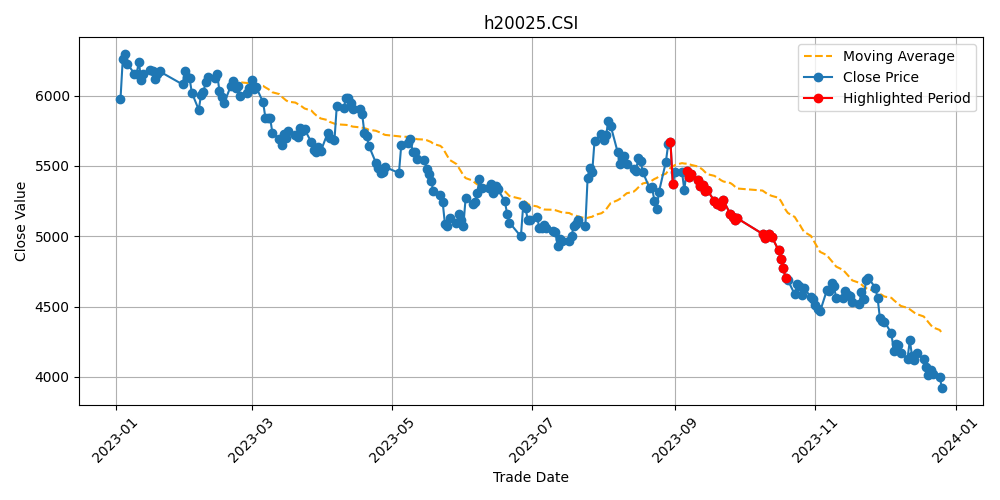


[(('2023-08-29', 1366.5343), ('2023-09-25', 1270.5227))]


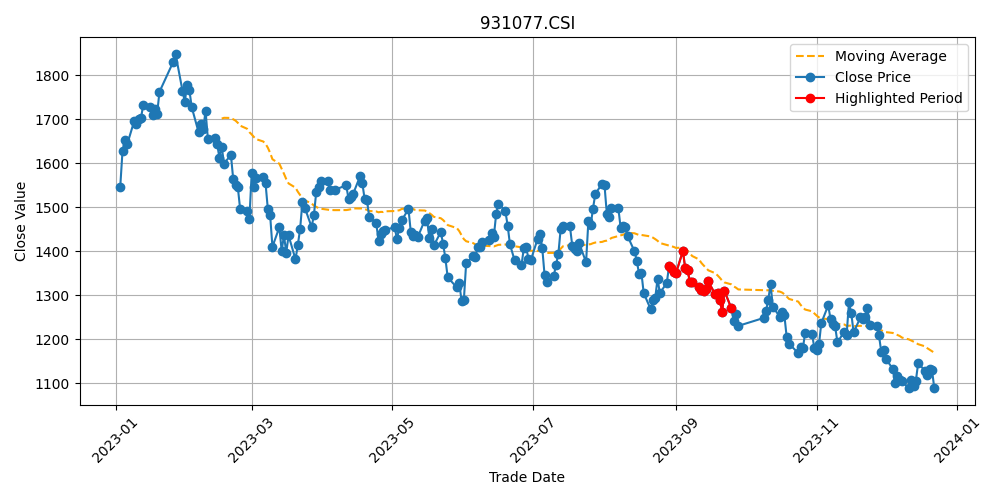


[(('2023-08-28', 640.136), ('2023-09-08', 600.1125))]


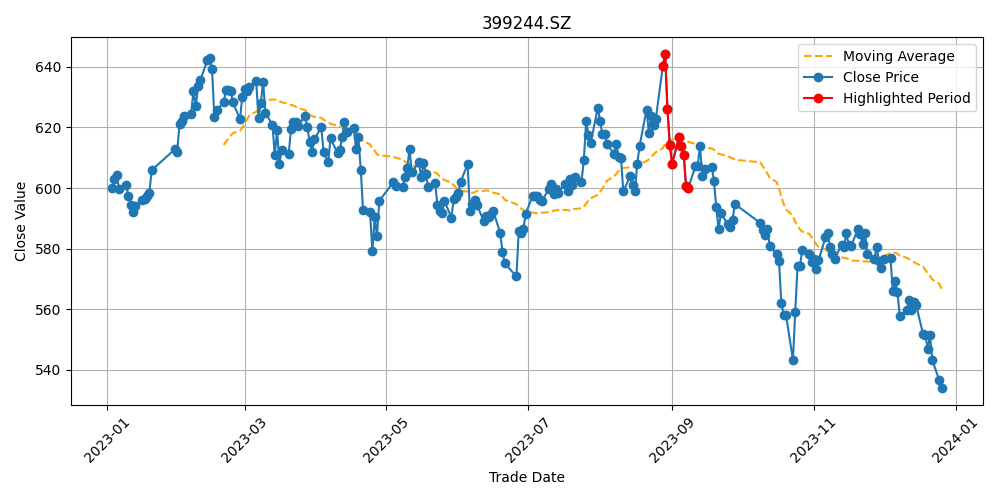


[(('2023-08-29', 1344.0437), ('2023-09-25', 1247.5575))]


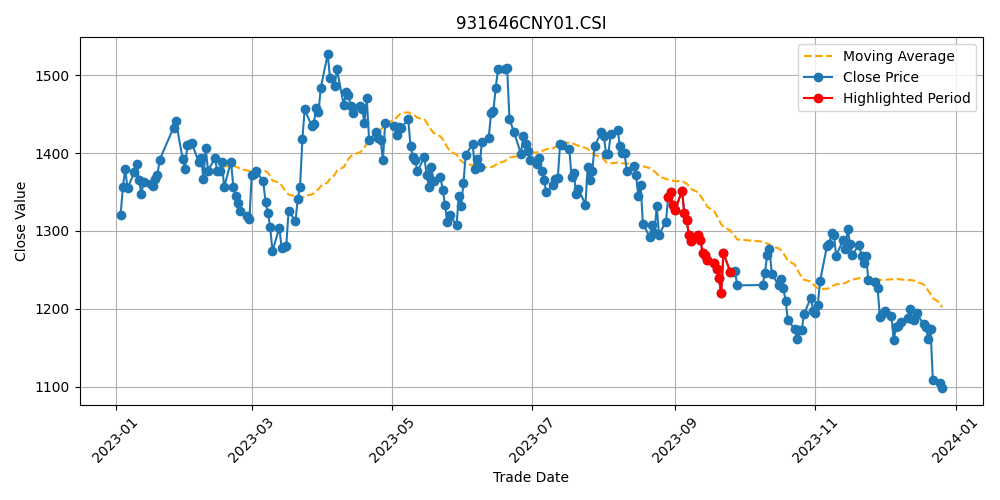


[(('2023-09-04', 1785.6873), ('2023-09-26', 1659.3306))]


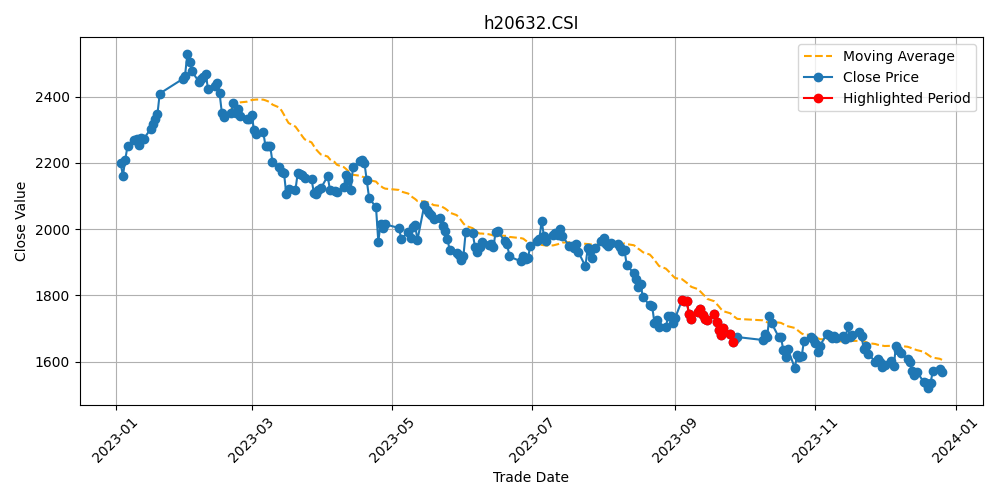


[(('2023-09-06', 5912.7329), ('2023-09-27', 6335.0402))]


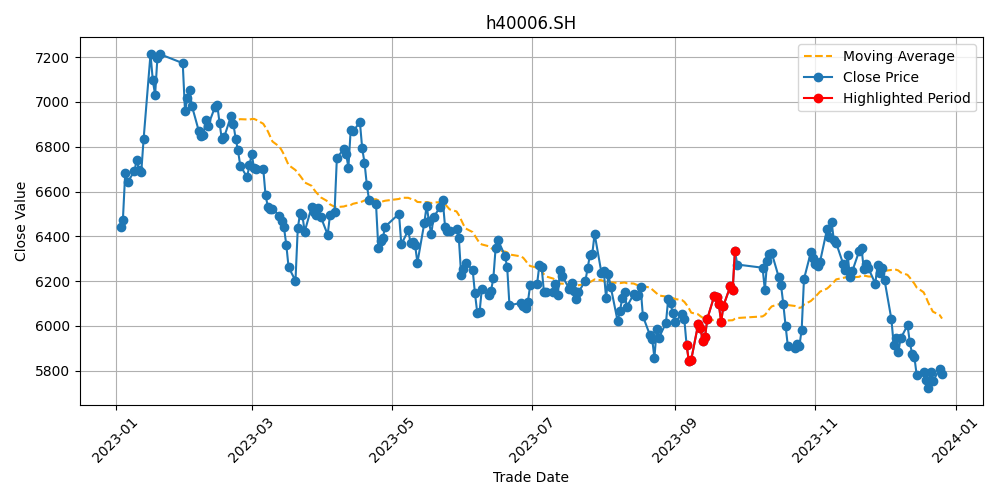


[(('2023-08-30', 6257.0308), ('2023-09-15', 5864.6939))]


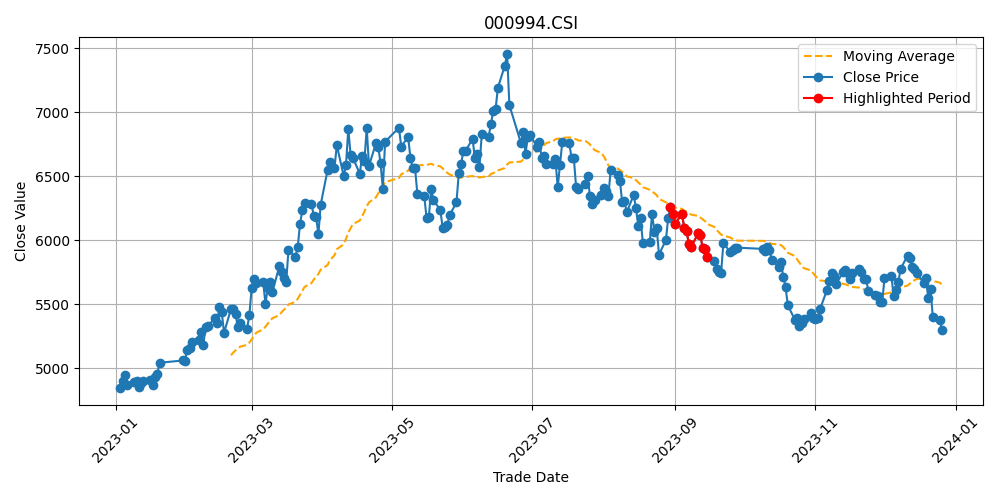


[(('2023-09-04', 2289.4566), ('2023-09-28', 2125.3902))]


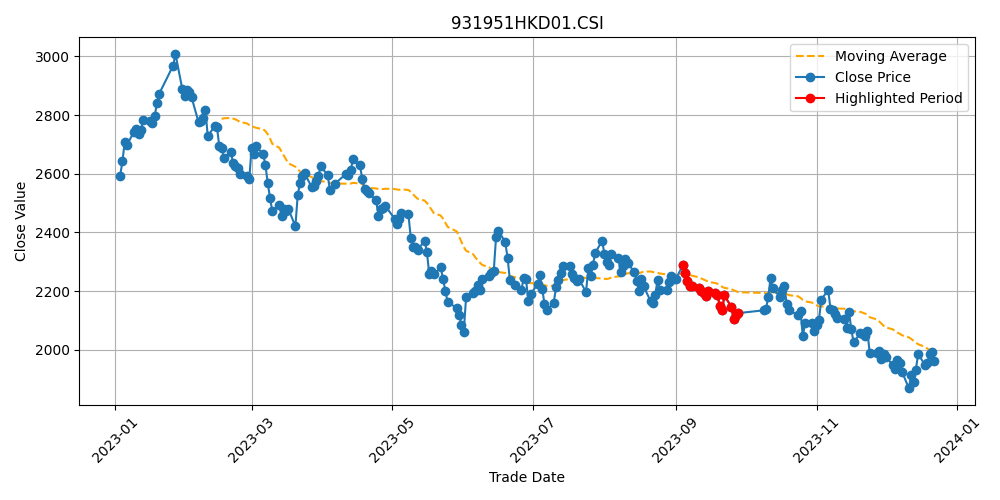


[(('2023-08-29', 3253.4399), ('2023-09-26', 3030.6805))]


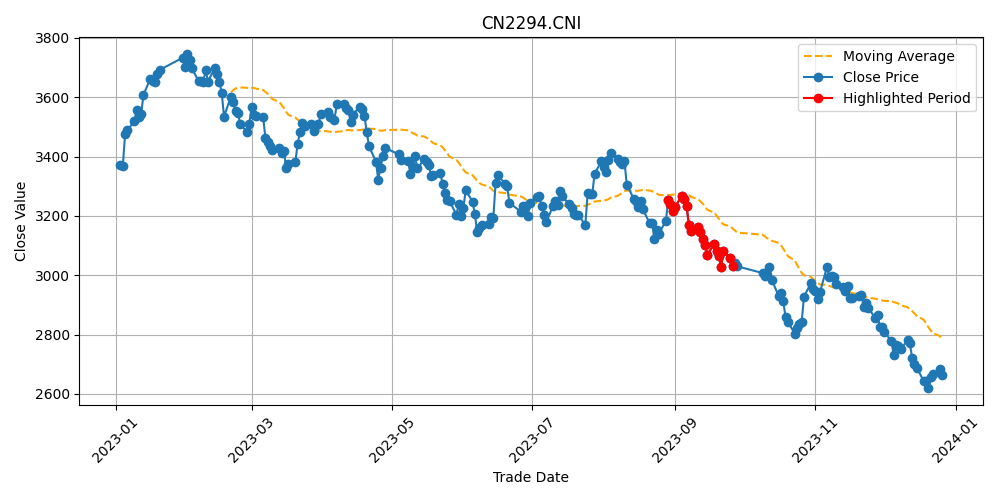


[(('2023-08-31', 4835.5539), ('2023-09-26', 4471.1056))]


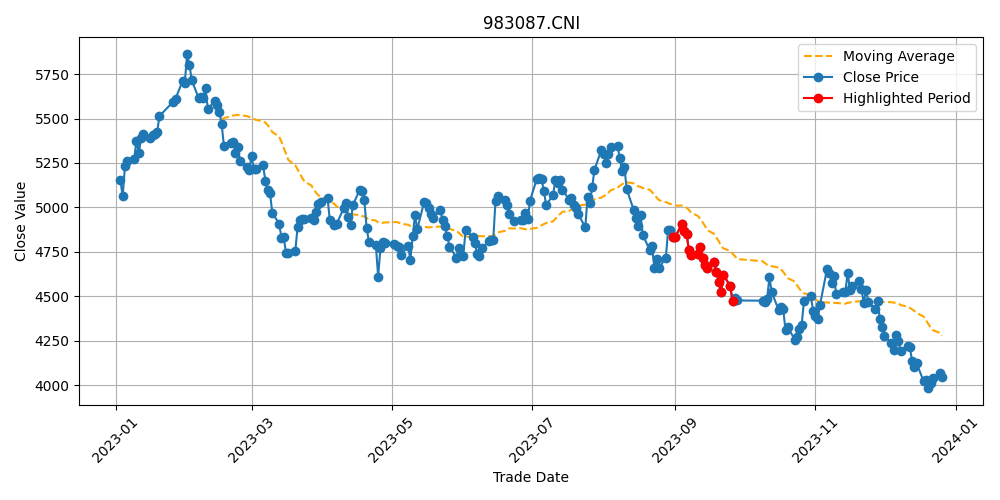


[(('2023-09-04', 3153.2905), ('2023-09-20', 2914.9467))]


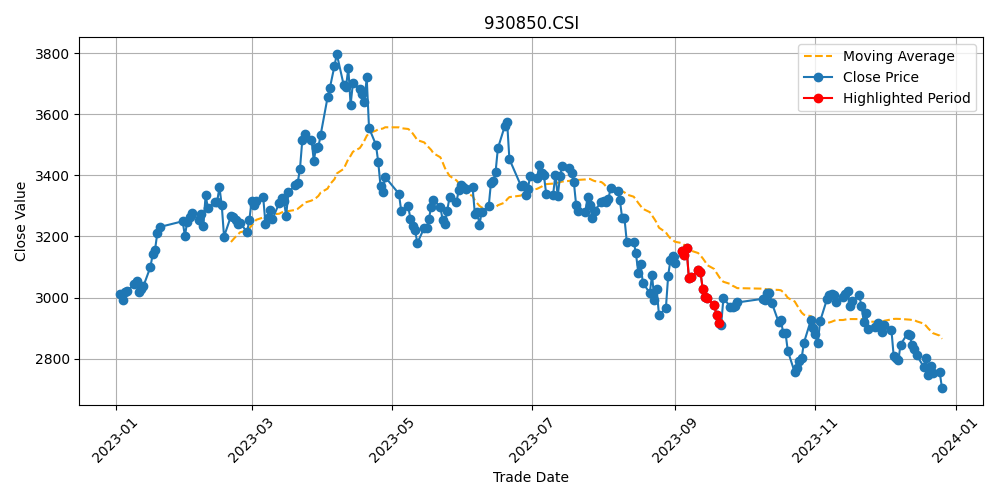


[(('2023-09-06', 3103.9723), ('2023-09-26', 2916.0686))]


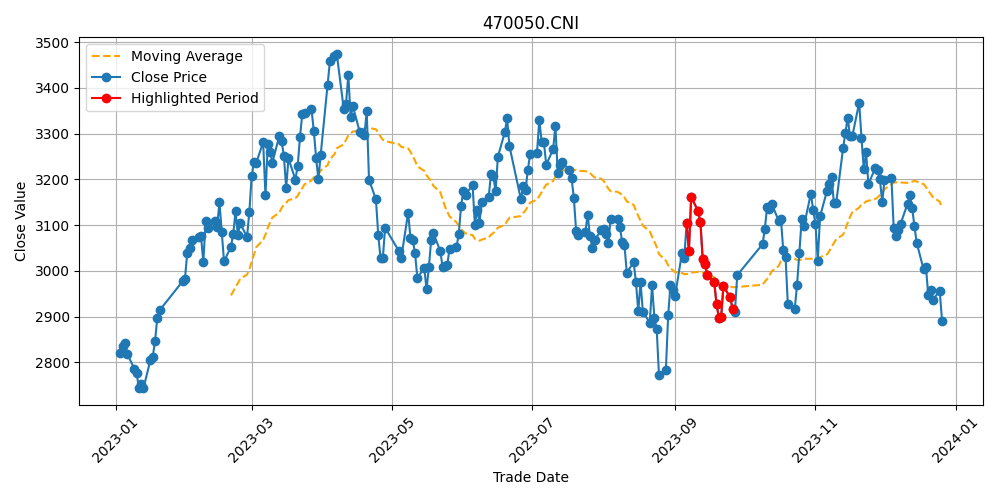


[(('2023-09-04', 6441.7873), ('2023-09-20', 6004.9604))]


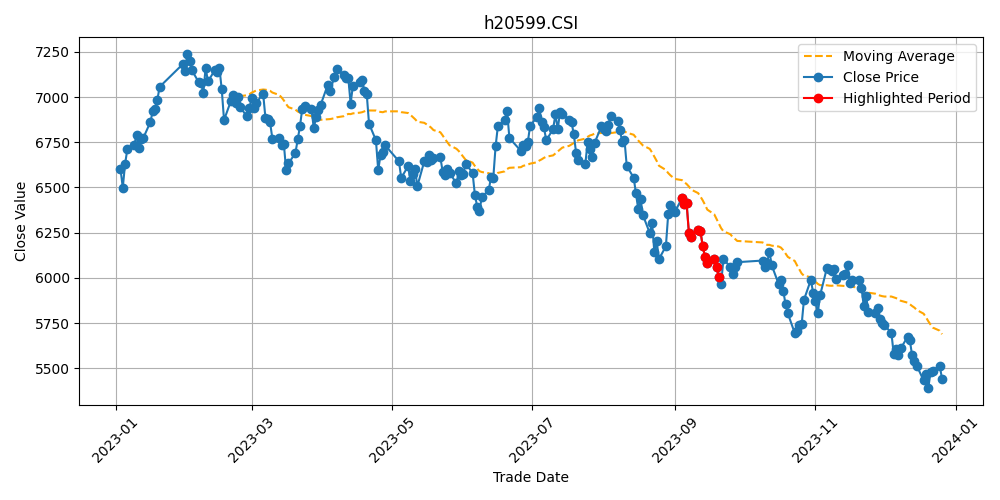


[(('2023-09-05', 12392.5255), ('2023-10-09', 13022.6416))]


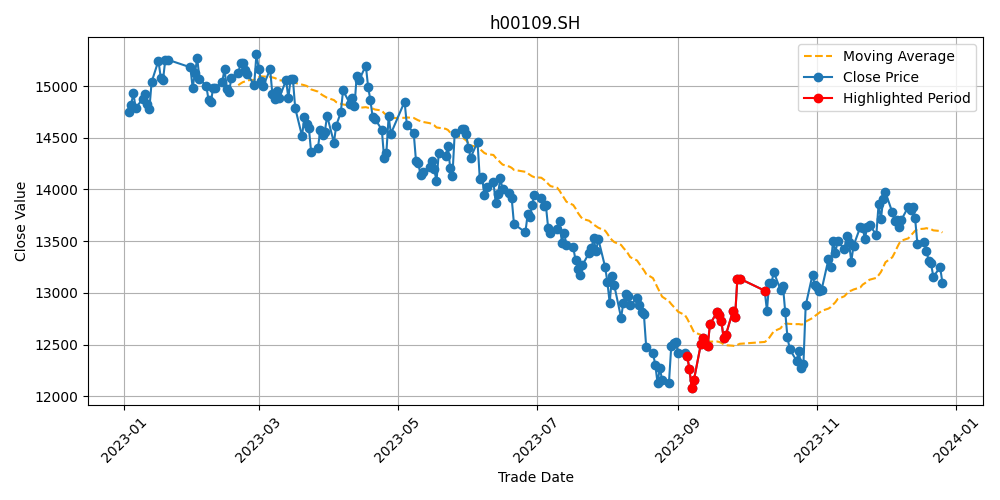


[(('2023-09-01', 1102.9614), ('2023-09-22', 1045.1833))]


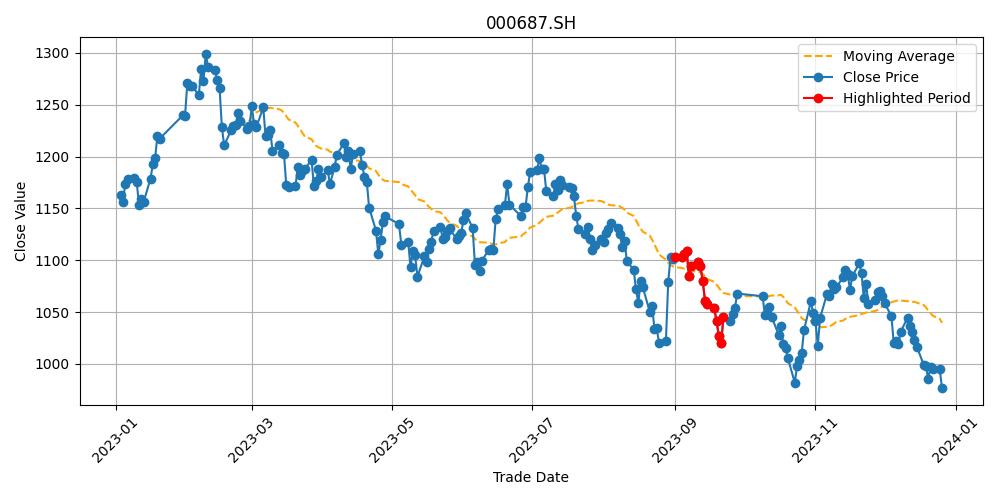


[(('2023-09-04', 3281.5904), ('2023-09-20', 3073.3374))]


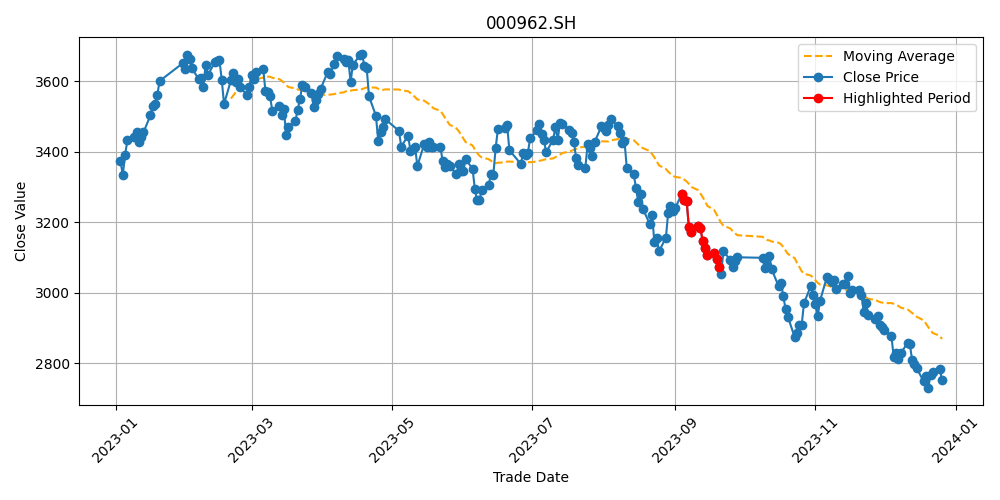


[(('2023-09-06', 5470.4344), ('2023-09-20', 5156.0703))]


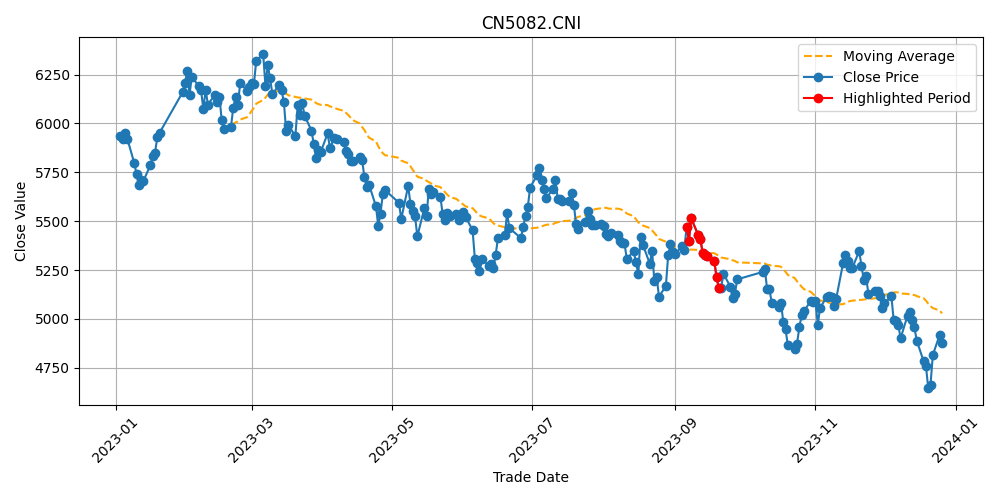


[(('2023-08-31', 2858.2626), ('2023-09-26', 2649.0402))]


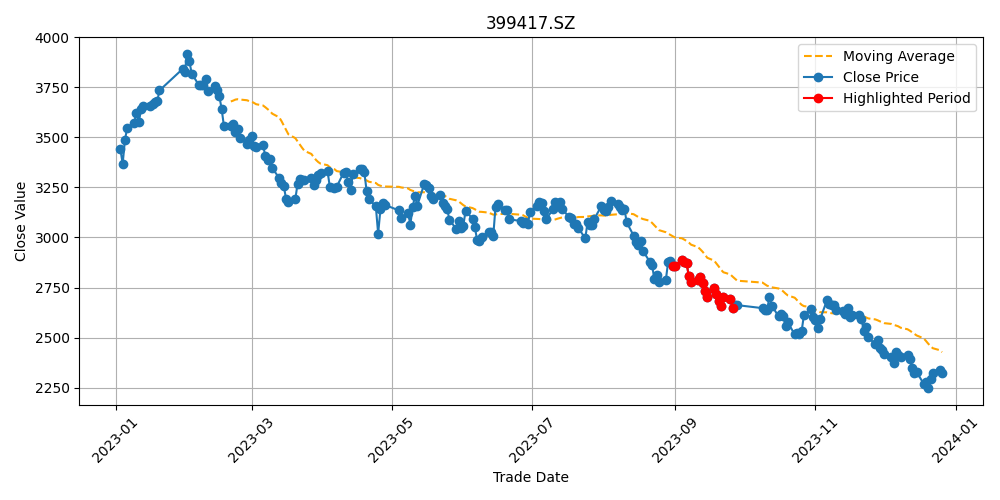


[(('2023-09-04', 457.2046), ('2023-10-13', 375.6609))]


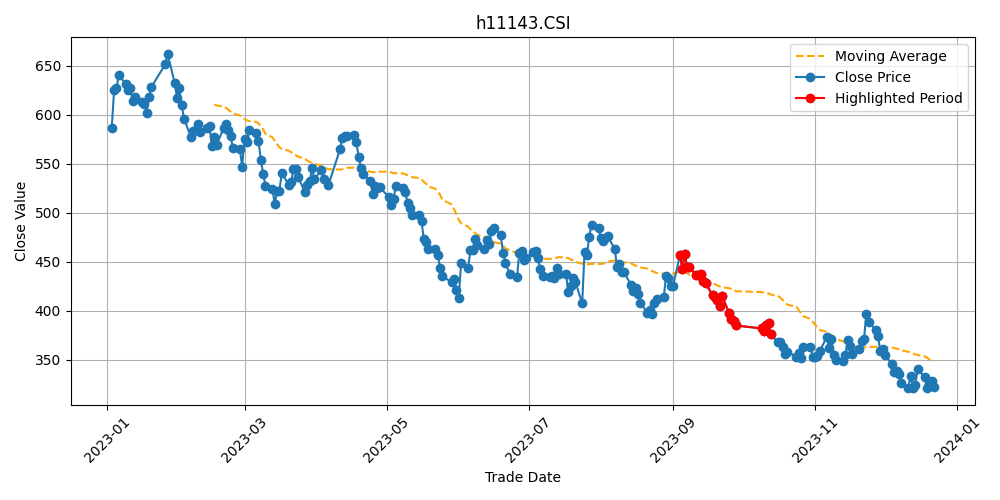


[(('2023-09-04', 11326.0272), ('2023-09-15', 10743.4027))]


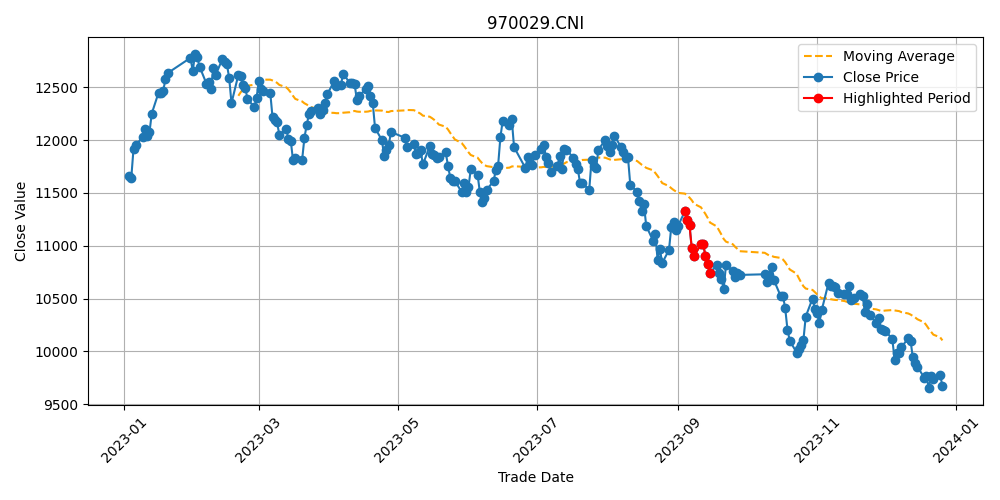


[(('2023-08-29', 1495.0887), ('2023-09-21', 1348.3367))]


C:\Users\jiawe\AppData\Local\Temp\ipykernel_23244\401393118.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 5))


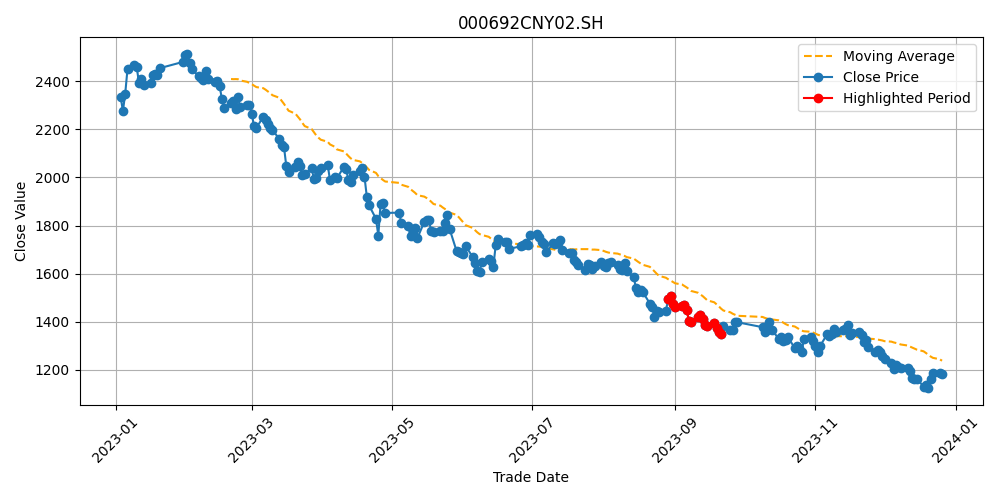


[(('2023-08-31', 3263.9356), ('2023-09-26', 3059.2127))]


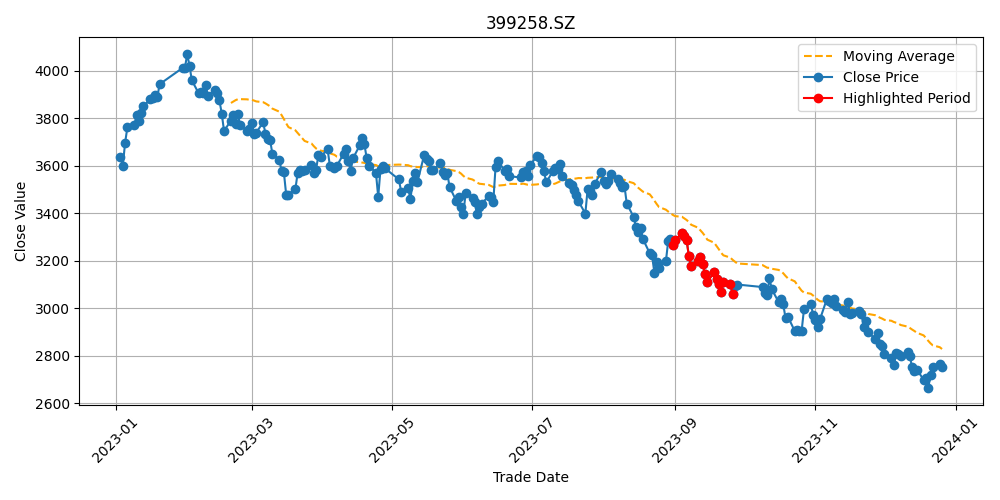


[(('2023-09-04', 10169.2454), ('2023-09-21', 9560.2616))]


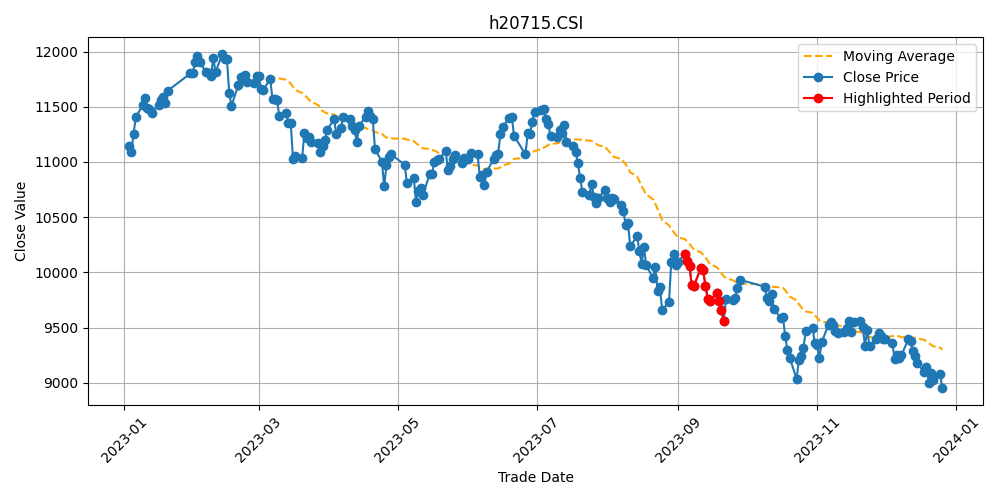


[(('2023-09-01', 1912.732), ('2023-09-21', 1813.6263))]


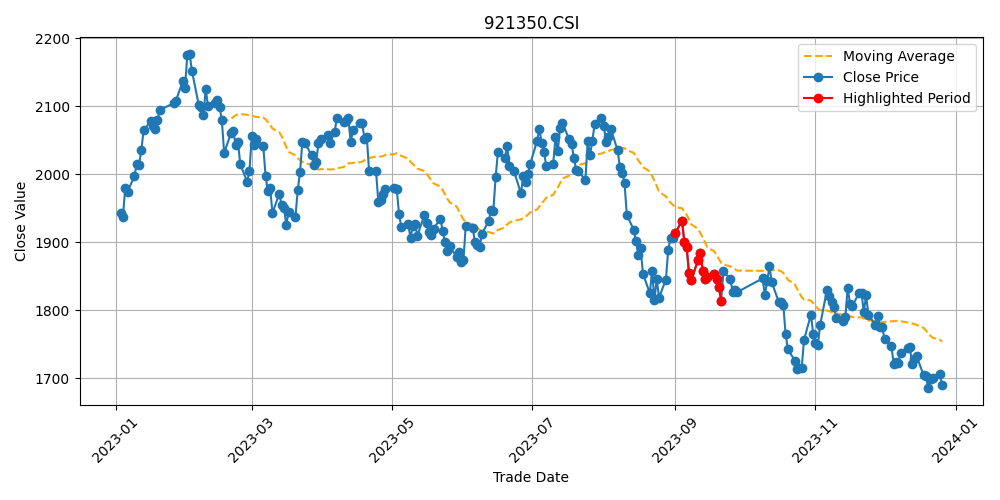


[(('2023-09-04', 1670.913), ('2023-09-21', 1574.8256))]


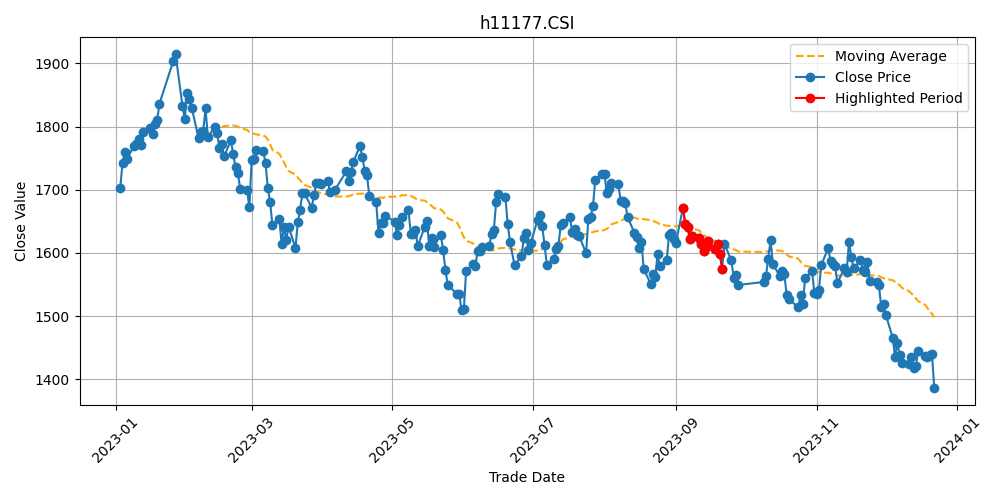


[(('2023-08-31', 5871.7018), ('2023-09-05', 6167.376))]


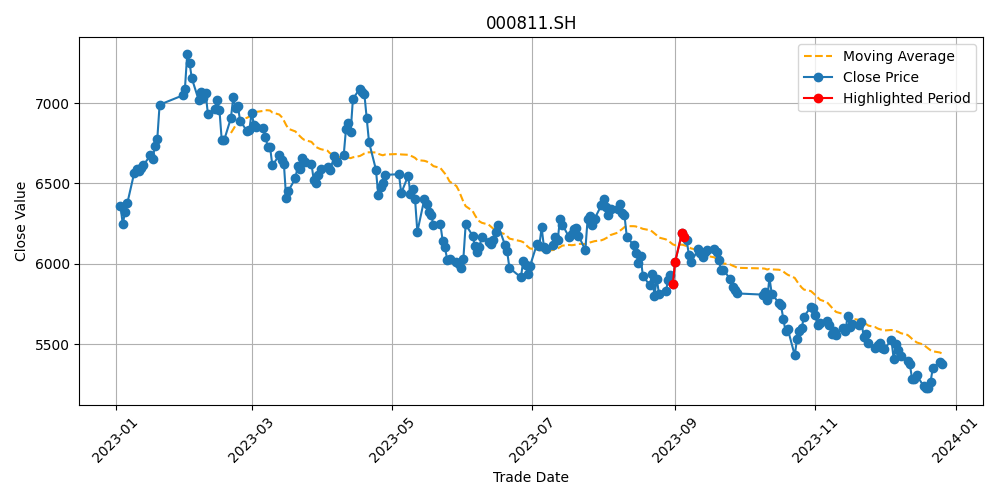


[(('2023-08-29', 1965.103), ('2023-09-07', 1864.7377))]


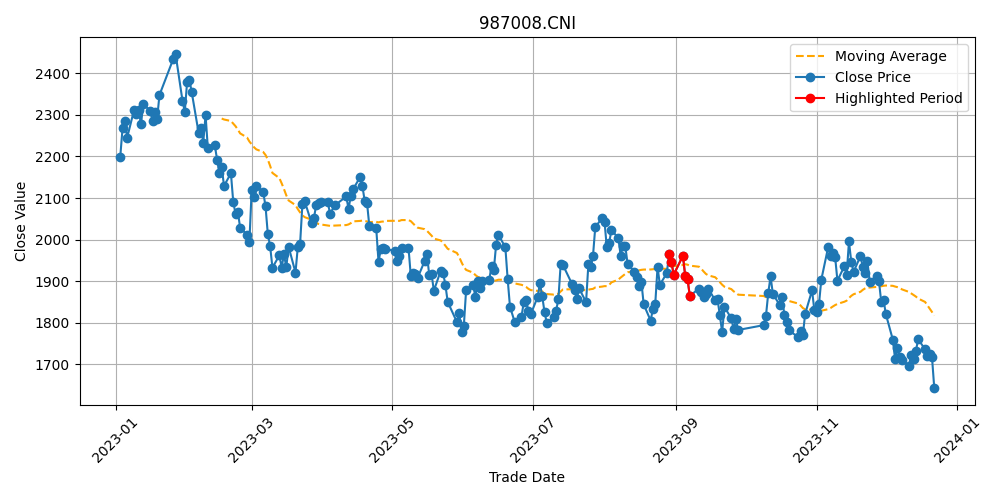


[(('2023-09-04', 2102.8217), ('2023-10-11', 1891.6137))]


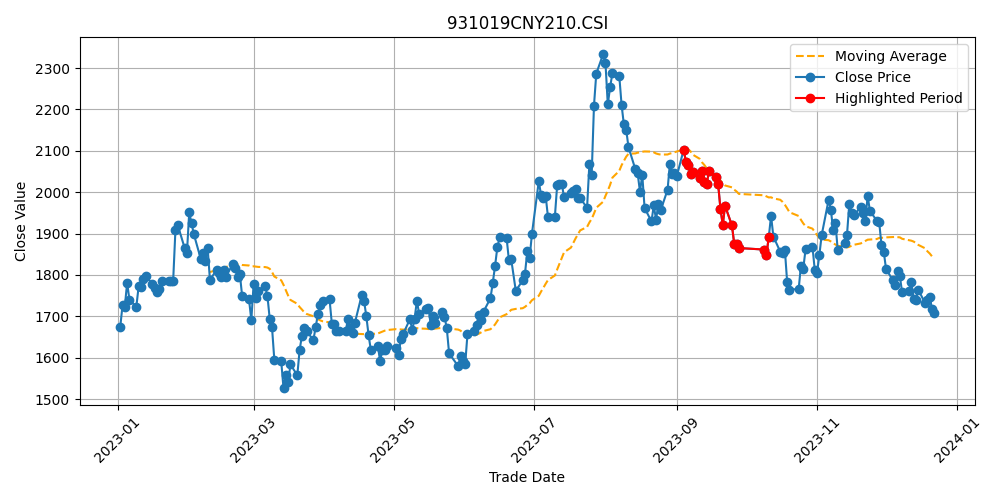


[(('2023-09-04', 1626.0025), ('2023-09-28', 1477.334))]


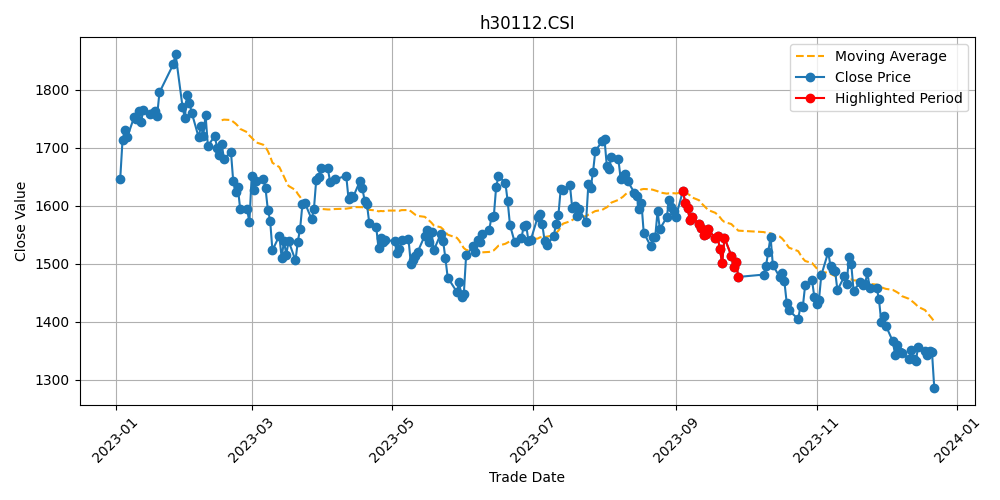


[(('2023-08-30', 1448.0784), ('2023-09-18', 1358.9919))]


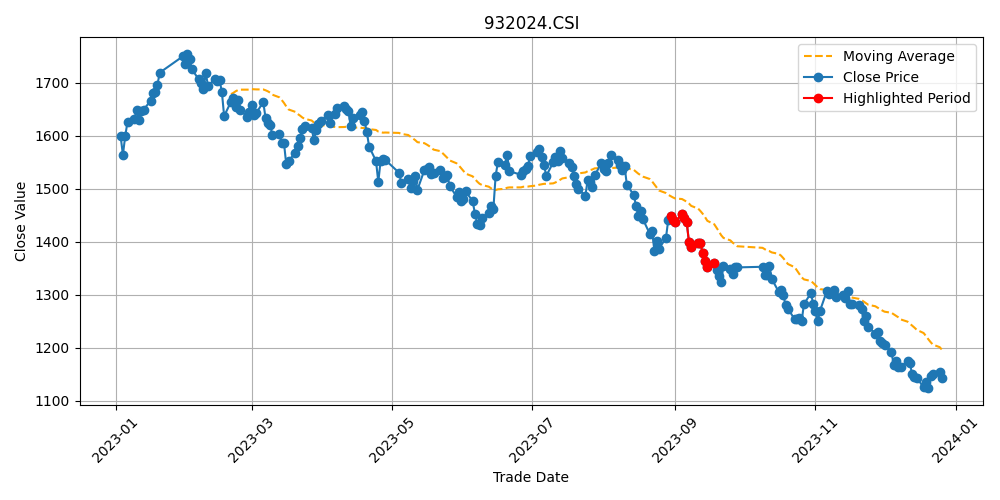


[(('2023-08-29', 1159.9732), ('2023-09-25', 1071.8606))]


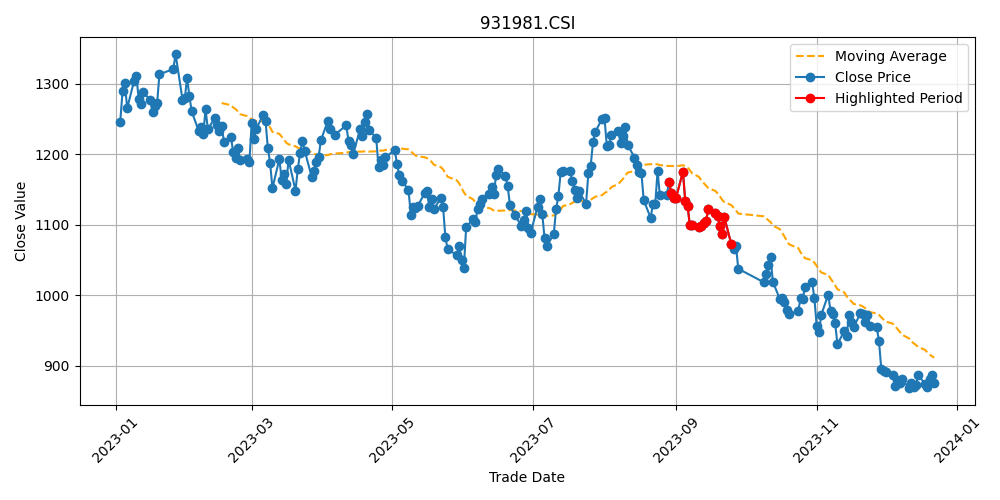


[(('2023-08-30', 2529.8998), ('2023-09-26', 2335.7405))]


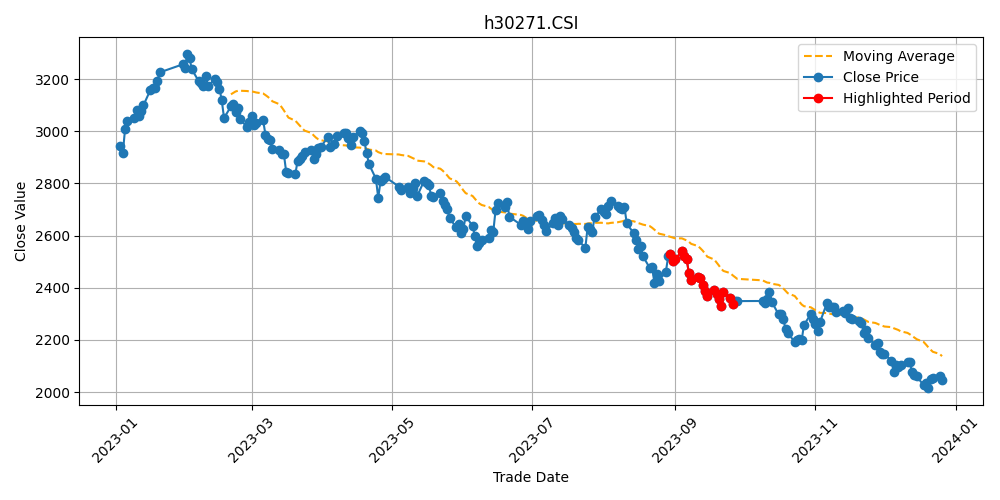


[(('2023-08-31', 2977.3319), ('2023-09-26', 2818.5738))]


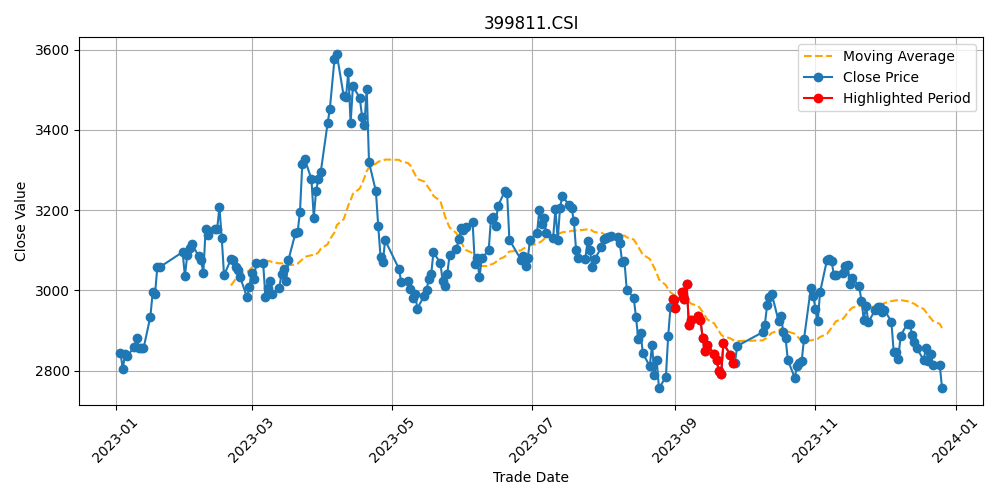


[(('2023-08-29', 1809.3523), ('2023-09-25', 1668.434))]


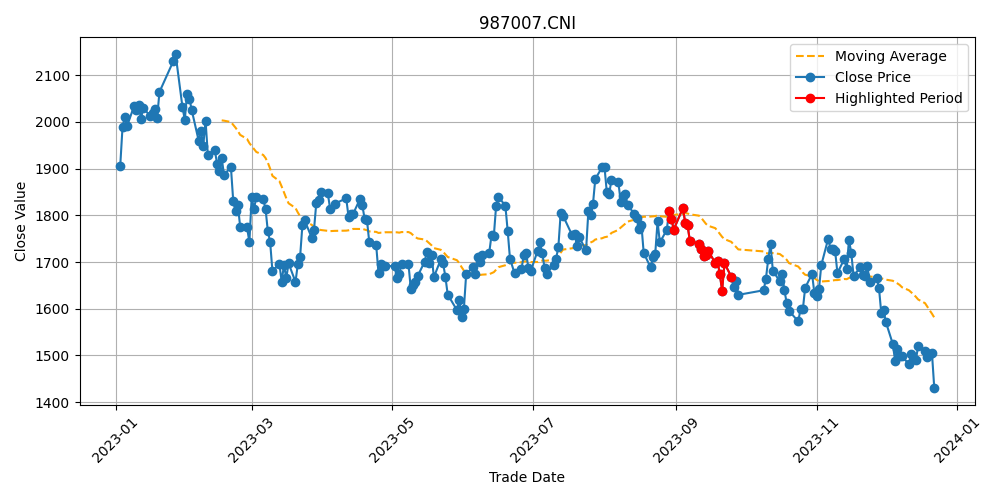


[(('2023-09-04', 8056.0212), ('2023-09-26', 7646.7289))]


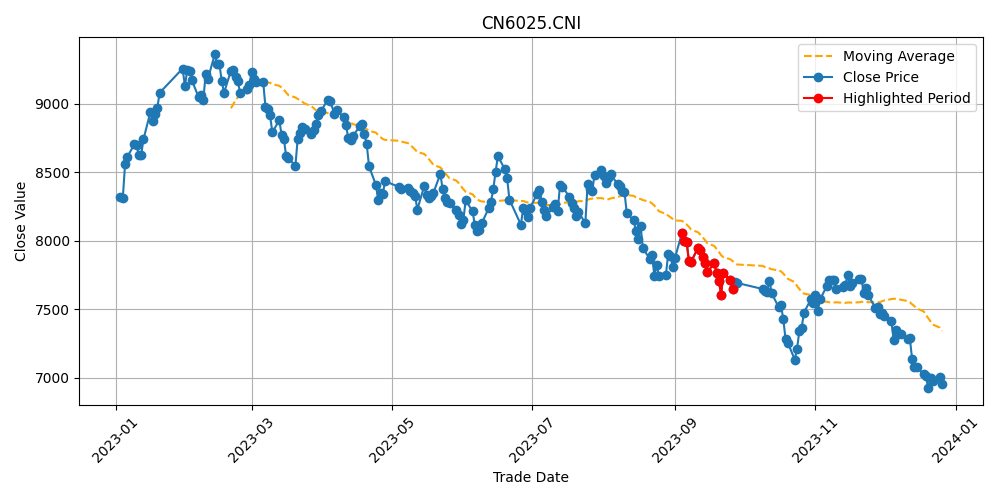


[(('2023-09-04', 452.9181), ('2023-10-13', 374.6901))]


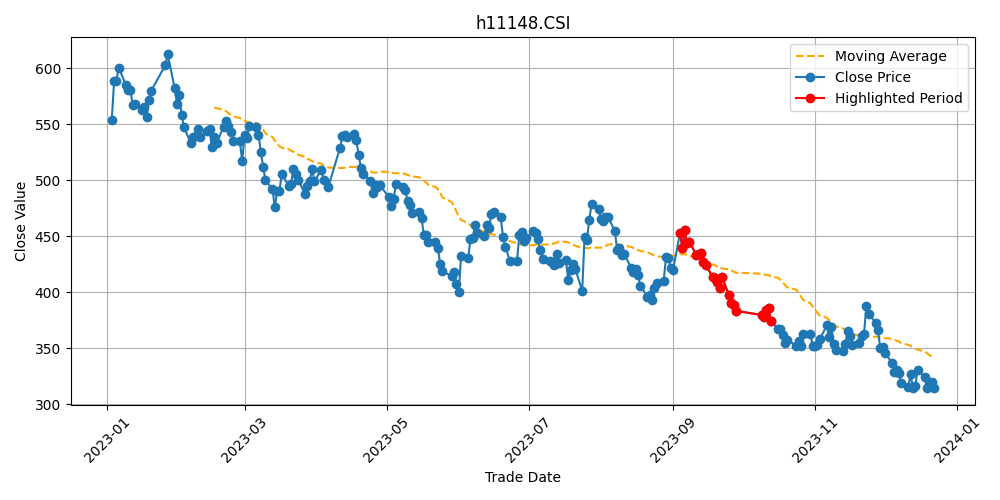


[(('2023-09-04', 1091.464), ('2023-09-22', 1021.1947))]


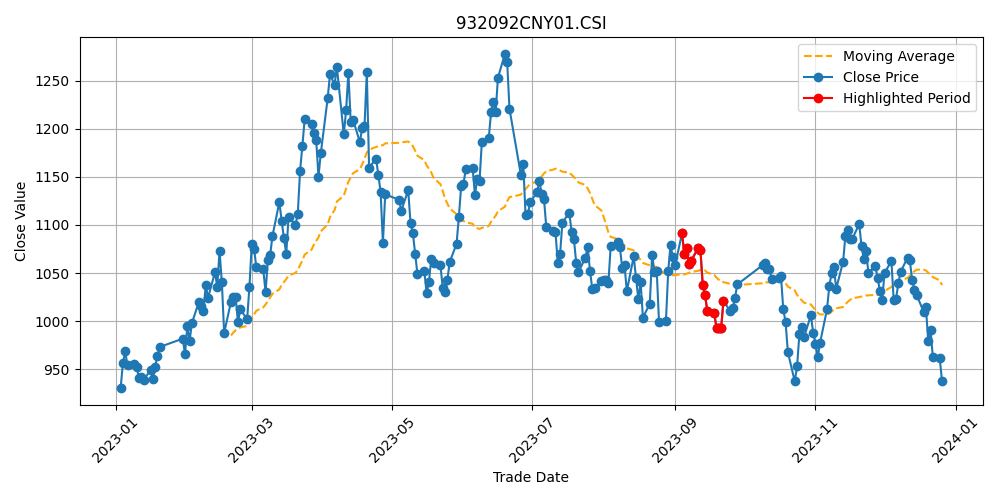


[(('2023-08-30', 4277.3981), ('2023-09-25', 3990.9851))]


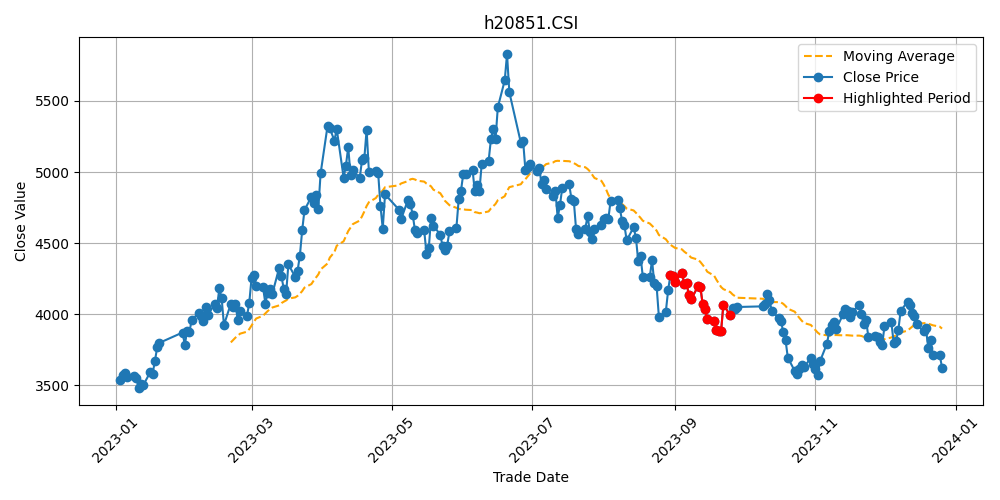


[(('2023-08-30', 7088.069), ('2023-09-15', 6661.9887))]


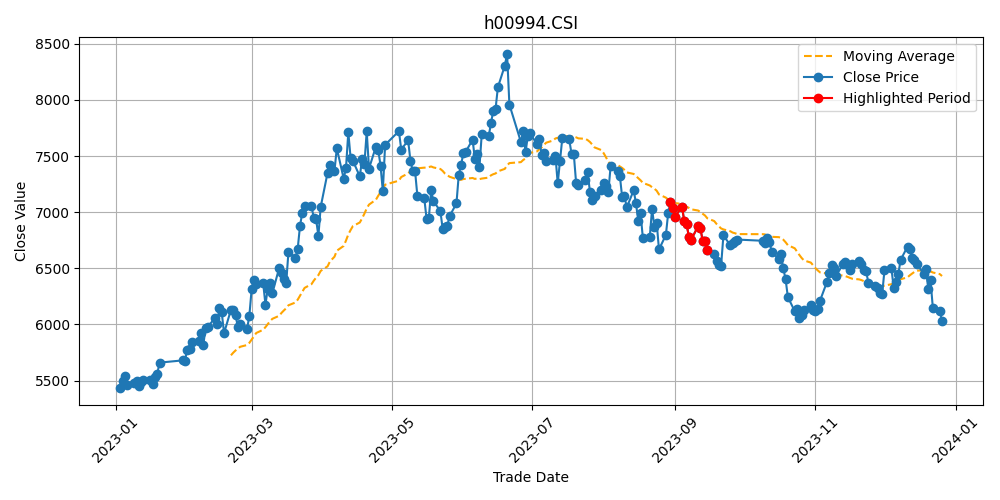


[(('2023-09-04', 3757.614), ('2023-09-26', 3343.0852))]


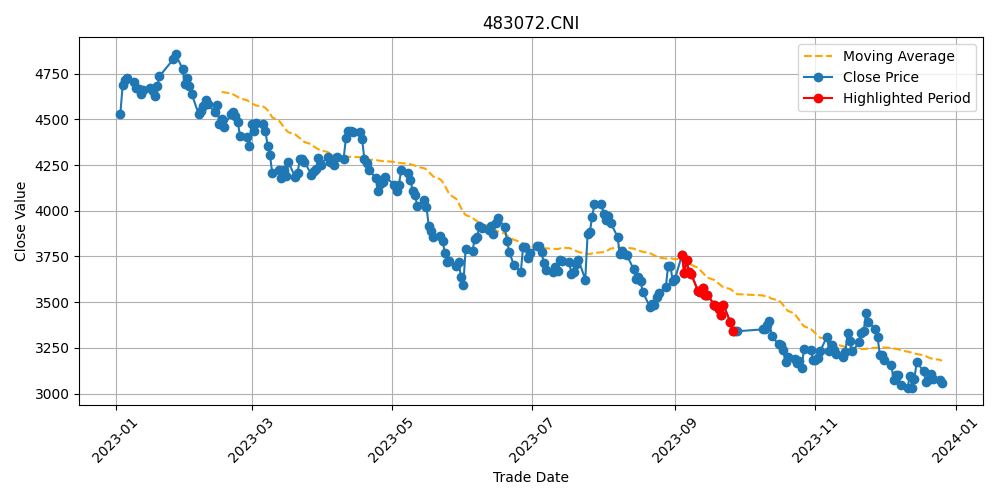


[(('2023-09-06', 8772.1649), ('2023-10-12', 9543.9757))]


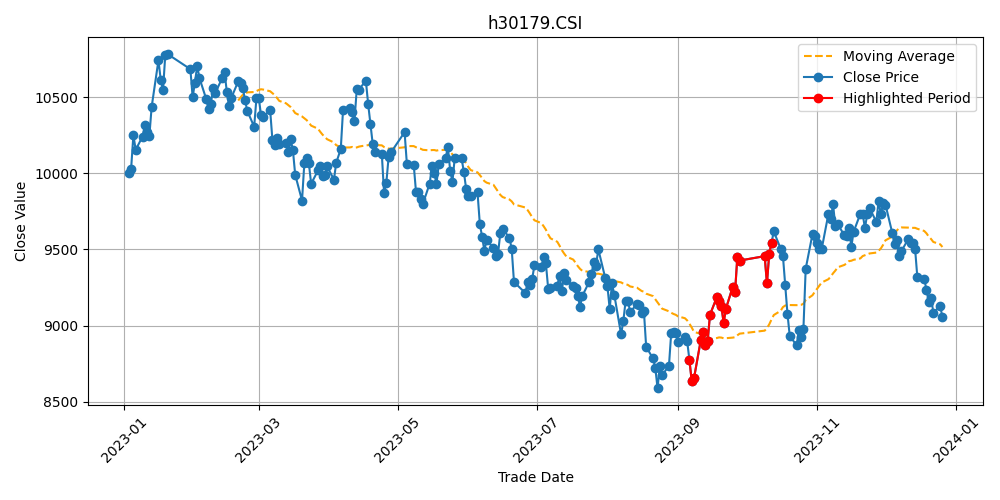


[(('2023-08-29', 646.8117), ('2023-09-07', 613.1855))]


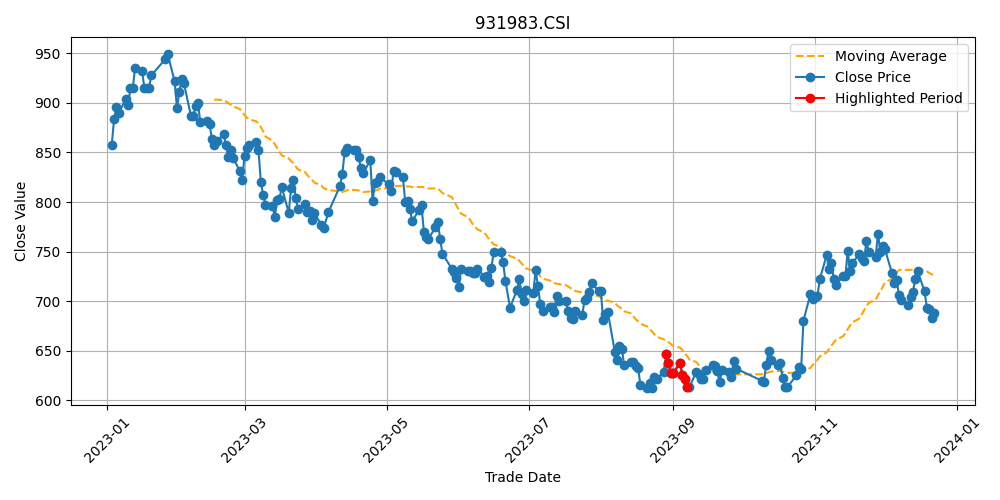


[(('2023-08-29', 805.9485), ('2023-09-21', 717.2315))]


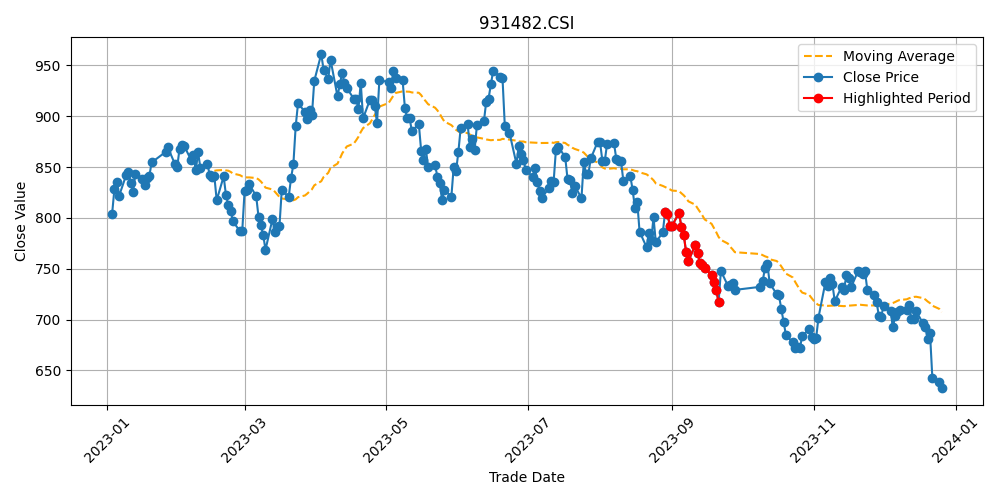


[(('2023-09-04', 4604.215), ('2023-09-28', 4213.8675))]


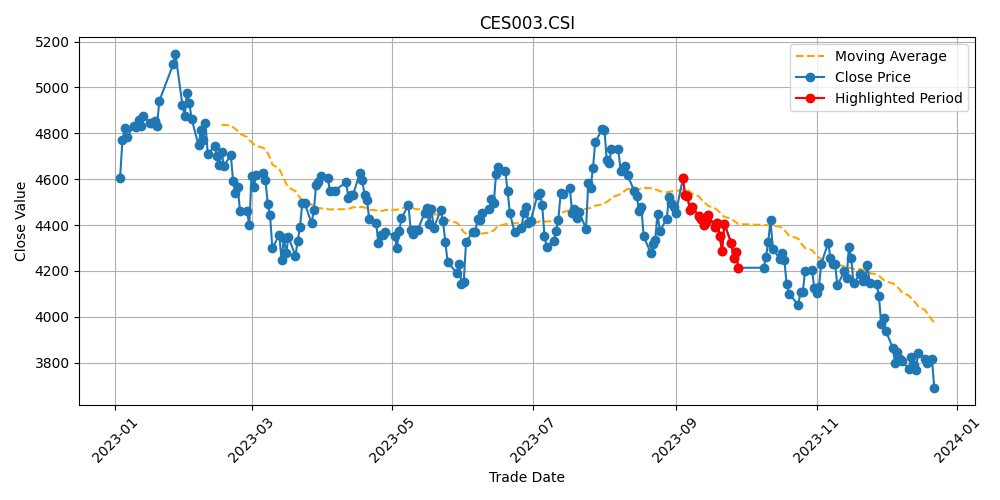


[(('2023-09-04', 2597.922), ('2023-09-21', 2452.2682))]


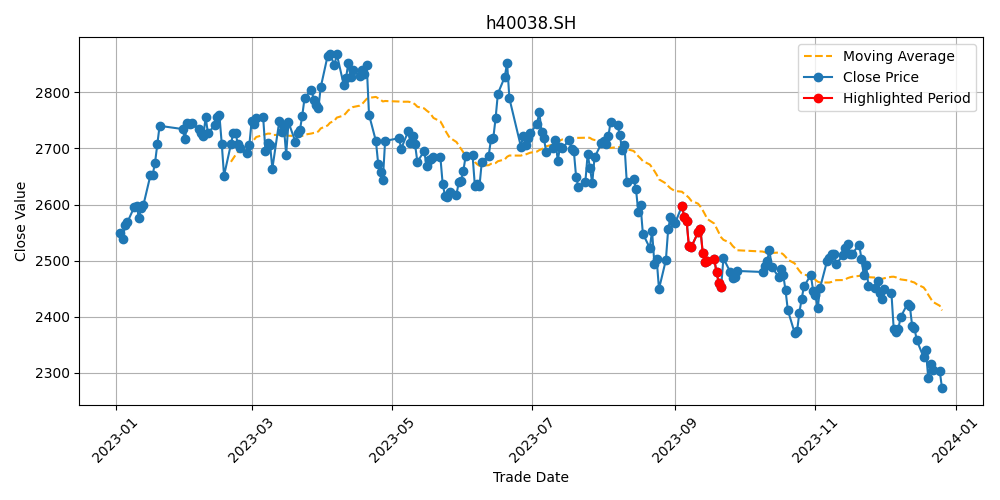


[(('2023-08-29', 2465.9841), ('2023-09-26', 2232.0192))]


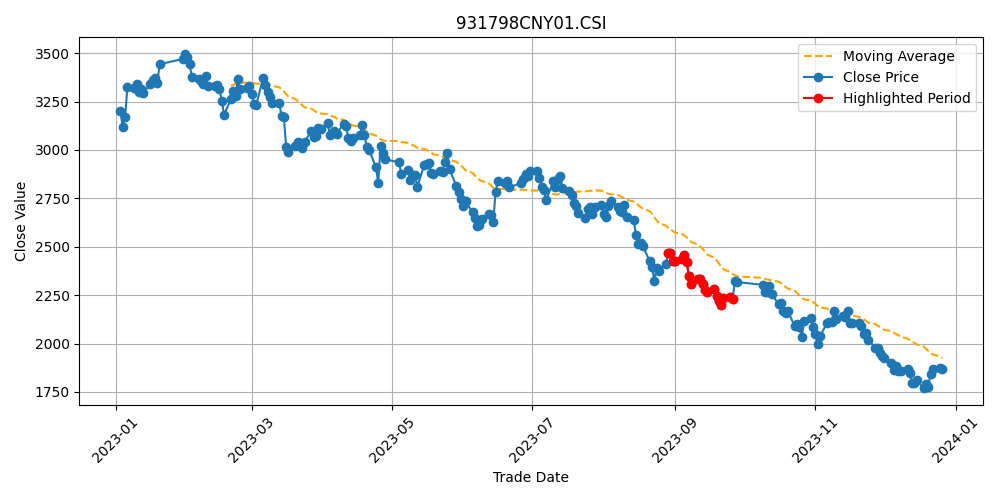


[(('2023-09-04', 2822.1791), ('2023-09-26', 2508.4193))]


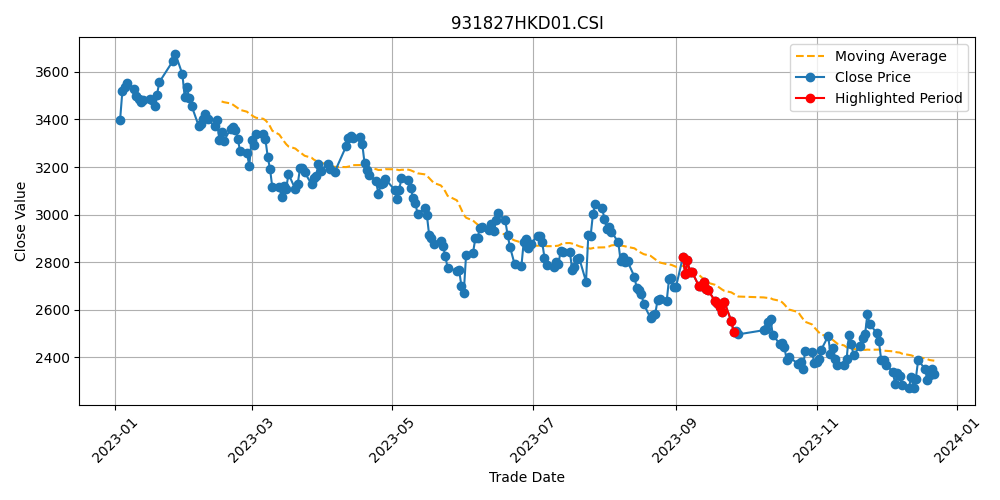


[(('2023-08-29', 646.8117), ('2023-09-07', 613.1855))]


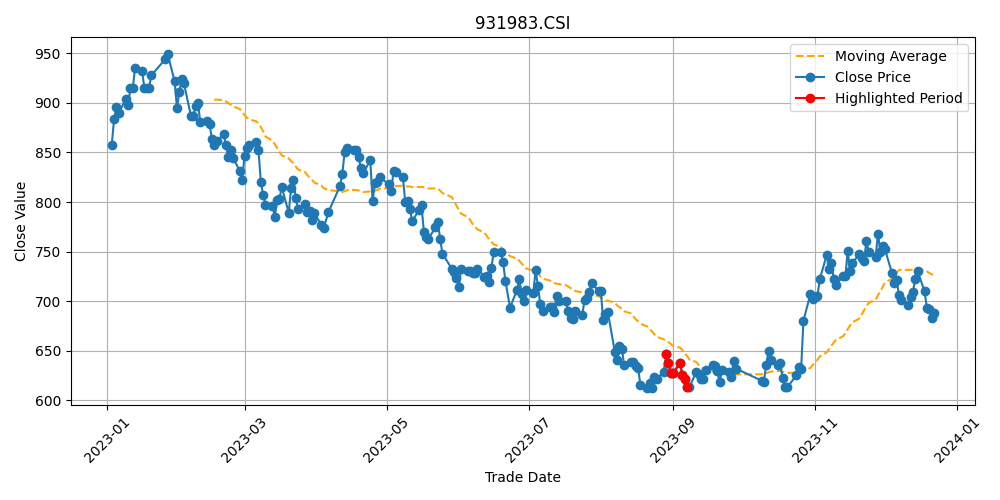


[(('2023-09-04', 4855.6002), ('2023-09-18', 4598.3726))]


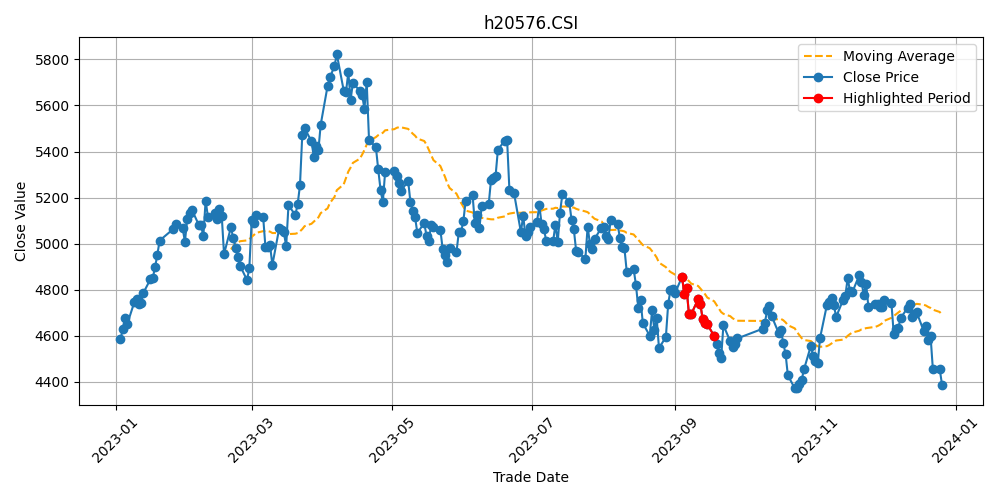


[(('2023-08-31', 2819.876), ('2023-09-26', 2669.7345))]


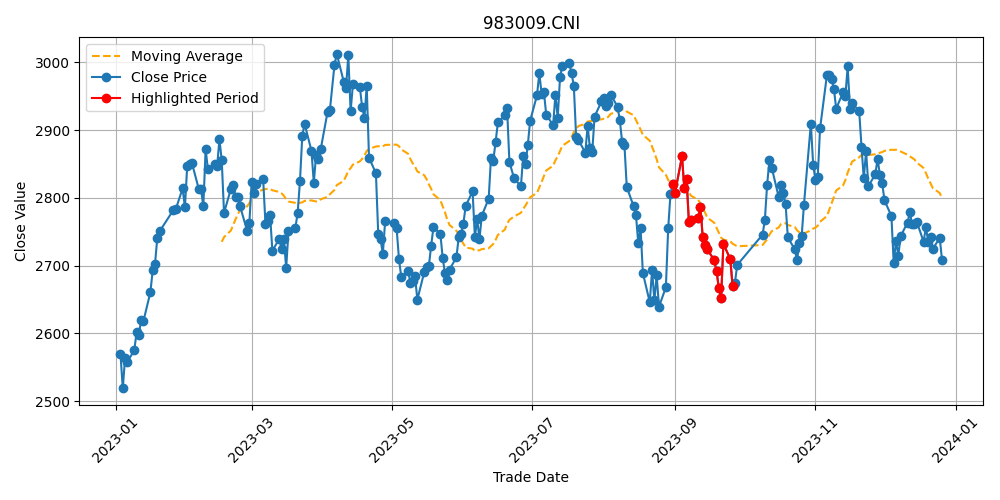


[(('2023-09-04', 2675.1073), ('2023-09-20', 2525.6169))]


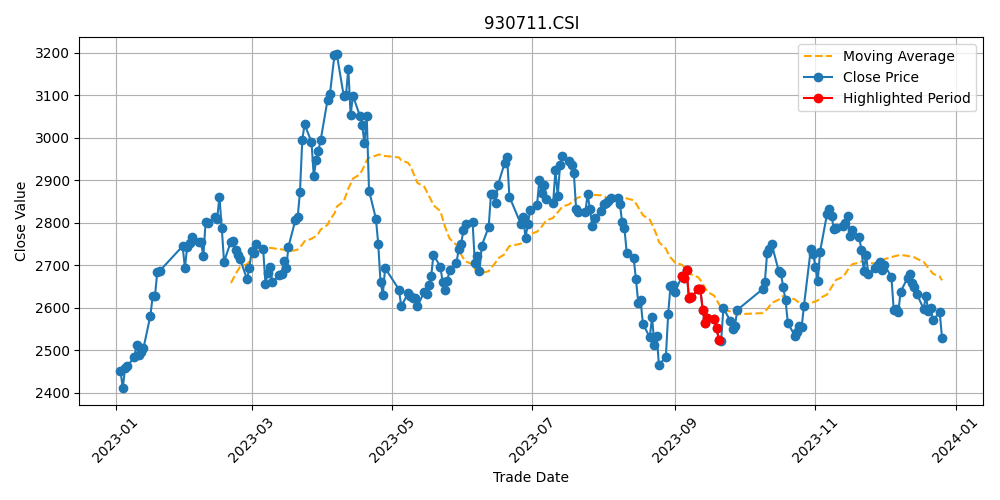

In [6]:
"""
Run
"""

count = 0
ird_codes = list(asset_dfs.keys())
while count <= 50:
    ird_code = random.choice(ird_codes)
    df = asset_dfs[ird_code]
    
    up, down = select_asset(ird_code=ird_code, df=df)
    
    if len(up) != 0 or len(down) != 0:
        count += 1
        print()

In [7]:
# ird_codes = list(asset_dfs.keys())  # Get all the ird_code from the keys of the dictionary
# ird_code = random.choice(ird_codes)  # Randomly select one ird_code
# ird_code = 'h21014.CSI'
# df = asset_dfs[ird_code]

# date_record_self_up = find_turning_point_self(df, direction=1, fraction_movement=0.01, threshold_day=22, n_days=7)
# asset_whole_period_visualisation(ird_code, df, date_record=date_record_self_up)

# date_record_self_down = find_turning_point_self(df, direction=-1, fraction_movement=0.01, threshold_day=22, n_days=7)
# asset_whole_period_visualisation(ird_code, df, date_record=date_record_self_down)

# date_record_ma = find_turning_point_ma(df)
# asset_whole_period_visualisation(ird_code, df, date_record=date_record_ma)

# date_record_hma = find_turning_point_hma(df)
# asset_whole_period_visualisation(ird_code, df, date_record=date_record_hma)